# Synthetic Control

INTRO

## Self-Driving Cars

Suppose you were a **ride-sharing platform** and you want to test the effect of self-driving cars in your fleet. 

As you can imagine, there are many **limitations** to running an AB/test for this type of feature. First of all, it's complicated to randomize individual rides. Second, it's a very expensive intervention. Third, and statistically most important, you cannot run this intervention at the ride level. The problem is that there are **spillover** effects from treated to control units: if indeed self-driving cars are more efficient, it means that they can serve more customers in the same amount of time, reducing the customers available to normal drivers (the control group). This spillover **contaminates** the experiment and prevents a causal interpretation of the results.

For all these reasons, we select only one city at random to run this experiment... (drum roll)... Miami!

<img src="fig/miami2.jpg" width="700px"/>

I generate a simulated dataset in which we observe a panel of U.S. cities over time. The revenue data is made up, while the socio-economic variables are taken from the [OECD database](https://stats.oecd.org/). I import the data generating process `dgp_selfdriving()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_selfdriving

treatment_year = 2013
treated_city = 'Miami'
df = dgp_selfdriving().generate_data(year=treatment_year, city=treated_city)
df.head()

,city,year,density,employment,gdp,population,treated,post,revenue
0,Atlanta,2003,290,0.629761,6.4523,4.267538,False,False,25.713947
1,Atlanta,2004,295,0.635595,6.5836,4.349712,False,False,23.852279
2,Atlanta,2005,302,0.645614,6.6998,4.455273,False,False,24.332397
3,Atlanta,2006,313,0.648573,6.5653,4.609096,False,False,23.816017
4,Atlanta,2007,321,0.650976,6.4184,4.737037,False,False,25.786902


In [3]:
len(df.city.unique())

46

We have information on the largest 46 U.S. cities for the period 2002-2019. The panel is **balanced**, which means that we observe all cities for all time periods.

Is the **treated** unit, Miami, comparable to the rest of the sample? Let's use the `create_table_one` function from Uber's [`causalml`](https://causalml.readthedocs.io/) package to produce a **covariate balance table**, containing the average value of our observable characteristics, across treatment and control groups. As the name suggests, this should always be the first table you present in causal inference analysis.

In [4]:
from causalml.match import create_table_one

create_table_one(df, 'treated', ['density', 'employment', 'gdp', 'population', 'revenue'])

,Control,Treatment,SMD
Variable,,,
n,765,17,
density,256.63 (172.90),364.94 (19.61),0.8802
employment,0.63 (0.05),0.60 (0.04),-0.5266
gdp,6.07 (1.16),5.12 (0.29),-1.1124
population,3.53 (3.81),5.85 (0.31),0.861
revenue,25.25 (2.45),23.86 (2.39),-0.5737


As expected, the groups are **not balanced**: Miami is more densely populated, poorer, larger and has lower employment rate than the other cities in the US in our sample. 

We are interested in understanding the impact of the introduction of **self-driving cars** on `revenue`. 

One initial idea could be to analyze the data as we would in an A/B test, comparing control and treatment group. We can estimate the treatment effect as a difference in means in `revenue` between the treatment and control group, after the introduction of self-driving cars.

In [5]:
smf.ols('revenue ~ treated', data=df[df['post']==True]).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,26.6006,0.127,210.061,0.000,26.351,26.850
treated[T.True],-0.7156,0.859,-0.833,0.405,-2.405,0.974


The effect of self-driving cars seems to be negative but not significant.

The main **problem** here is that we have a **single treated unit**: Miami. It's very hard to argue that Miami is comparable to other cities. Randomization ensures that this simple estimator is unbiased, ex-ante. However, with a single treated unit, the estimator suffers from severe small sample bias .

One alternative procedure, is to compare revenue **before and after** the treatment, within the city of Miami.

In [6]:
smf.ols('revenue ~ post', data=df[df['city']==treated_city]).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,22.4485,0.534,42.044,0.000,21.310,23.587
post[T.True],3.4364,0.832,4.130,0.001,1.663,5.210


The effect of self-driving cars seems to be positive and statistically significant.

However, the **problem** of this procedure is that there might have been many **other things happening** after 2016. It's a very strong stretch to attribute all differences to self-driving cars. 

We can better understand this concern if we plot the time trend of revenue over cities. First, we need to reshape the data into a **wide format**, with one column per city and one row per year.

In [7]:
df = df.pivot(index='year', columns='city', values='revenue').reset_index()

Now, let's plot the revenue over time for Miami and for the other cities.

In [8]:
cities = [c for c in df.columns if c!='year']
df['Other Cities'] = df[[c for c in cities if c != treated_city]].mean(axis=1)

In [9]:
def plot_lines(df, line1, line2, year, hline=True):
    sns.lineplot(x=df['year'], y=df[line1].values, label=line1)
    sns.lineplot(x=df['year'], y=df[line2].values, label=line2)
    plt.axvline(x=year, ls=":", color='C2', label='Self-Driving Cars', zorder=1)
    plt.legend();
    plt.title("Average revenue per day (in M$)");

Since we are talking about Miami, let's use an appropriate color palette.

In [10]:
sns.set_palette(sns.color_palette(['#f14db3', '#0dc3e2', '#443a84']))

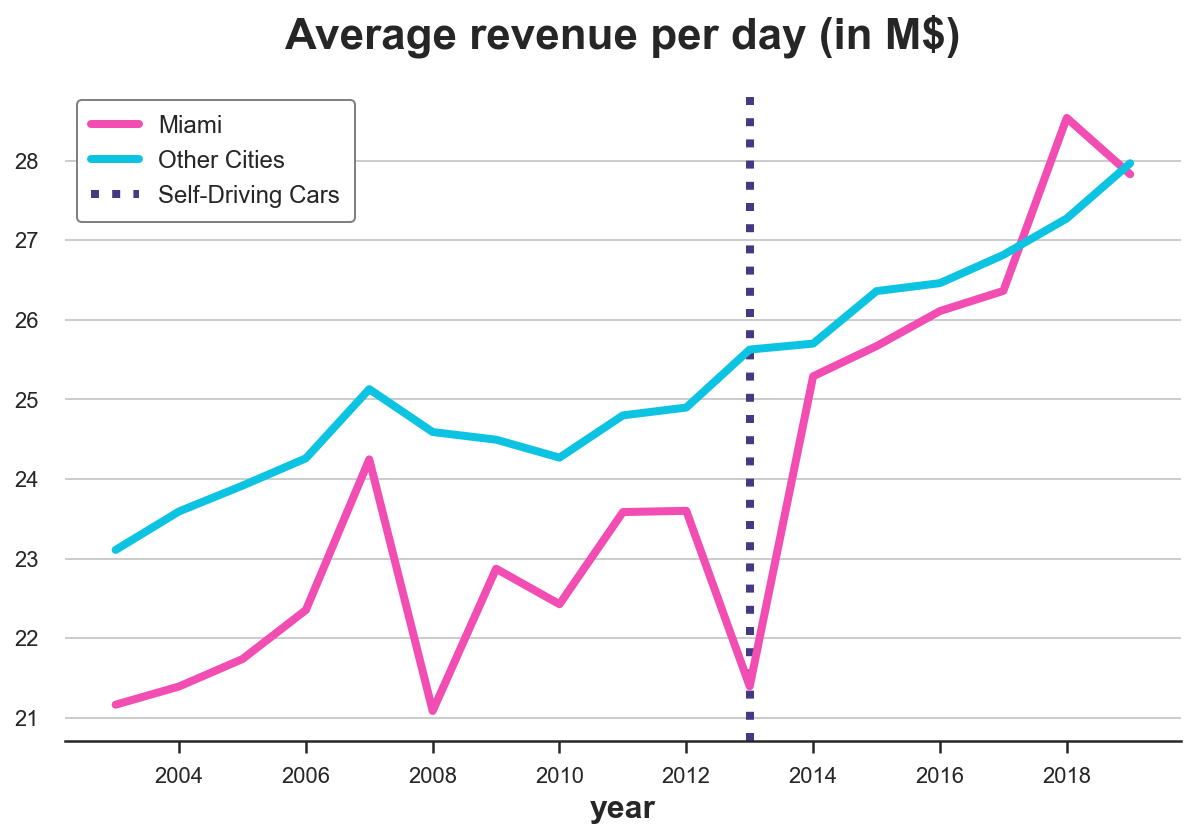

In [11]:
plot_lines(df, treated_city, 'Other Cities', treatment_year)

As we can see, revenue seems to be increasing after the treatment in Miami. But it's a very volatile time series. And revenue was increasing also in the rest of the country. It's very hard from this plot to attribute the change to self-driving case. 

Can we do better?

## Synthetic Control

The answer is yes! Synthetic control methods were first introduced by [Abadie, Diamond and Hainmueller (2010)](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) and allow us to do causal inference when we have as few as one treated unit and many control units and we observe them over time.

### Setting

We assume that for a panel of i.i.d. subjects $i = 1, ..., n$ over time $t=1, ...,T$ we observed a set of variables $(X_{it}, D_i, Y_{it})$ that includes

- a treatment assignment $D_i \in \lbrace 0, 1 \rbrace$ (`treated`)
- a response $Y_{i,t} \in \mathbb R$ (`revenue`)
- a feature vector $X_{i,t} \in \mathbb R^n$ (`population`, `density`, `employment` and `GDP`)


Moreover, one unit (Miami in our case) is treated at time $t^*$ (2016 in our case). We distinguish time periods before treatment and time periods after treatment.

Crucially, treatment $D_i$ is not randomly assigned, therefore a difference in means between the treated unit(s) and the control group is not an unbiased estimator of the average treatment effect.

### The Problem 

The problem is that, as usual, we do not observe the counterfactual outcome for treated units, i.e. we do not know what would have happened to them, if they had not been treated. This is known as the **fundamental problem of causal inference**.

The simplest approach, would be just to compare pre and post periods. This is called the **event study** approach.

However, we can do better than this. In fact, even though treatment was not randomly assigned, we still have access to some units that were not treated.

For the outcome variable we have the following setup

$$
Y = 
\begin{bmatrix}
Y_{t, post} \ & Y_{c, post} \newline 
Y_{t, pre} \ & Y_{c, pre} 
\end{bmatrix}
$$

which we can rewrite as 

$$
Y = 
\begin{bmatrix}
Y^{(1)} _ {t, post} \ & Y^{(0)} _ {c, post} \newline 
Y^{(0)} _ {t, pre} \ & Y^{(0)} _ {c, pre} 
\end{bmatrix}
$$

We basically have a **missing data problem** since we do not observe $Y^{(0)} _ {t, post}$.

### The Solution

Following [Doudchenko and Inbens (2018)](https://arxiv.org/pdf/1610.07748.pdf), we can formulate an estimate of the counterfactual outcome for the treated unit as a linear combination of the observed outcomes for the control units.

$$
\hat Y^{(0)} _ {t, post} = \alpha + \sum_{i \in c} \beta_{i} Y^{(0)} _ {i, post}
$$

where

- the constant $\alpha$ allows for different averages between the two groups
- the weights $\beta_i$ are allowed to vary across control units $i$ (otherwise, it would be a difference-in-differences)

How should we **choose which weights** to use? We want our synthetic control to approximate the outcome as closely as possible, before the treatment. The first approach could be to define the weights as

$$
\hat \beta = \arg \min_{\beta} || \boldsymbol X_{t, pre} - \boldsymbol \beta \boldsymbol X_{c, pre} || = \sqrt{ \sum_{p} \left( X_{t, p, pre}  - \sum_{i \in c} \beta_{p} X_{c, p, pre} \right)^2 }
$$

I.e. the weights are such that they minimize the distance between observable characteristics of control units $X_c$ and the treated unit $X_t$ before the treatment.

You might notice a very close similarity to **linear regression**.  Indeed, we are doing something very similar.

In linear regression, we usually have **many units** (observations), **few exogenous features** and **one endogenous feature** and we try to express the endogenous feature as a linear combination of the endogenous features, for each unit.

<img src="fig/synth1.png" width="500px"/>

With synthetic control, we instead have **many time periods** (features), few **control units** and a single **treated unit** and we try to express the treated unit as a linear combination of the control units, for each time period

<img src="fig/synth2.png" width="500px"/>

In the end, we are doing the same thing, but with a transposed dataset.

<img src="fig/synth3.png" width="500px"/>

### Back to self-driving cars

Let's go back to the data now! First, we write a `synth_predict` function that takes as input a model that is trained on control cities and tries to predict the outcome of the treated city, Miami, before the introduction of self-driving cars.

In [12]:
def synth_predict(df, model, city, year):
    other_cities = [c for c in cities if c not in ['year', city]]
    y = df.loc[df['year'] <= year, city]
    X = df.loc[df['year'] <= year, other_cities]
    df[f'Synthetic {city}'] = model.fit(X, y).predict(df[other_cities])
    return model

Let's estimate the model via linear regression.

In [13]:
from sklearn.linear_model import LinearRegression

coef = synth_predict(df, LinearRegression(), treated_city, treatment_year).coef_

How well did we **match** pre-self-driving cars `revenue` in Miami? What is the implied **effect** of self-driving cars? 

We can visually answer both questions by plotting the actual revenue in Miami against the predicted one.

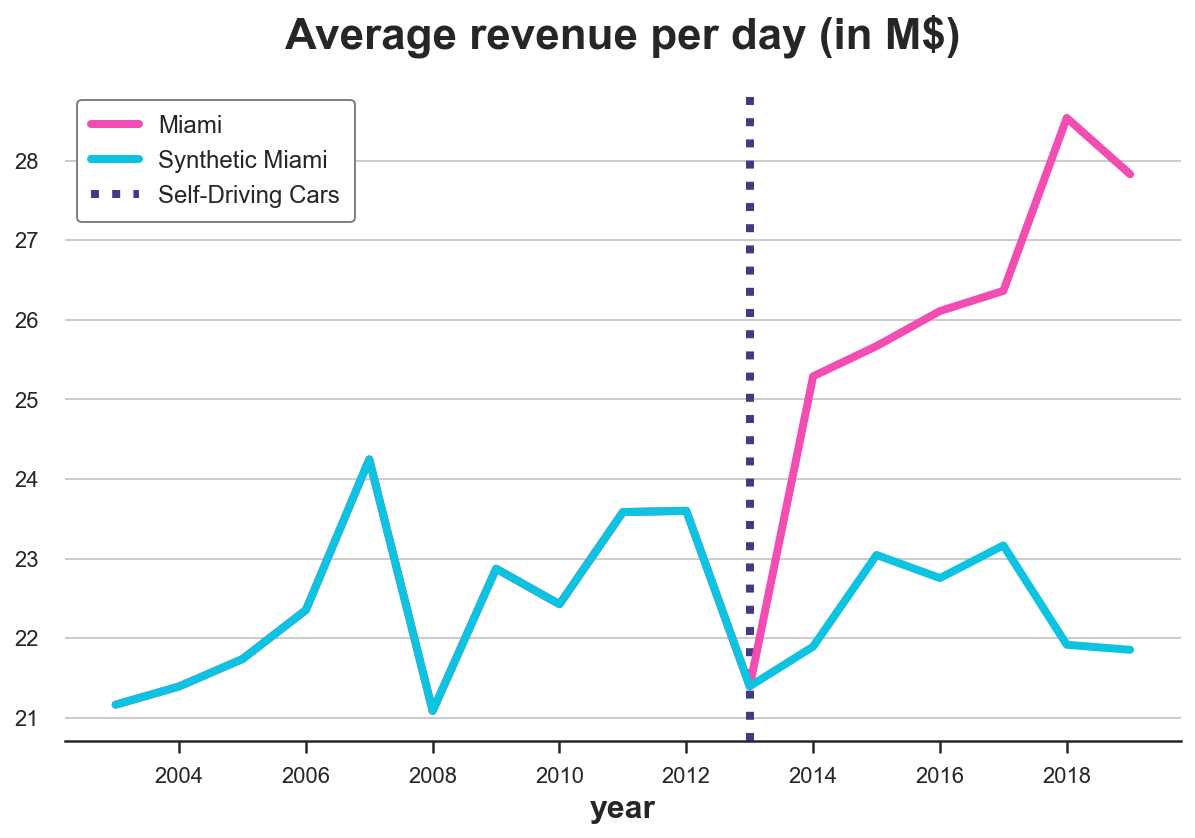

In [14]:
plot_lines(df, treated_city, f'Synthetic {treated_city}', treatment_year)

It looks like self-driving cars had a sensible **positive effect** on `revenue` in Miami: the predicted trend is lower than the actual data and diverges right after the introduction of self-driving cars.

On the other hand, we are clearly **overfitting**: the pre-treatment predicted `revenue` line is perfectly overlapping with the actual data. Given the high variability of `revenue` in Miami, this is suspicious, to say the least.

Another problem concerns the **weights**. Let's plot them.

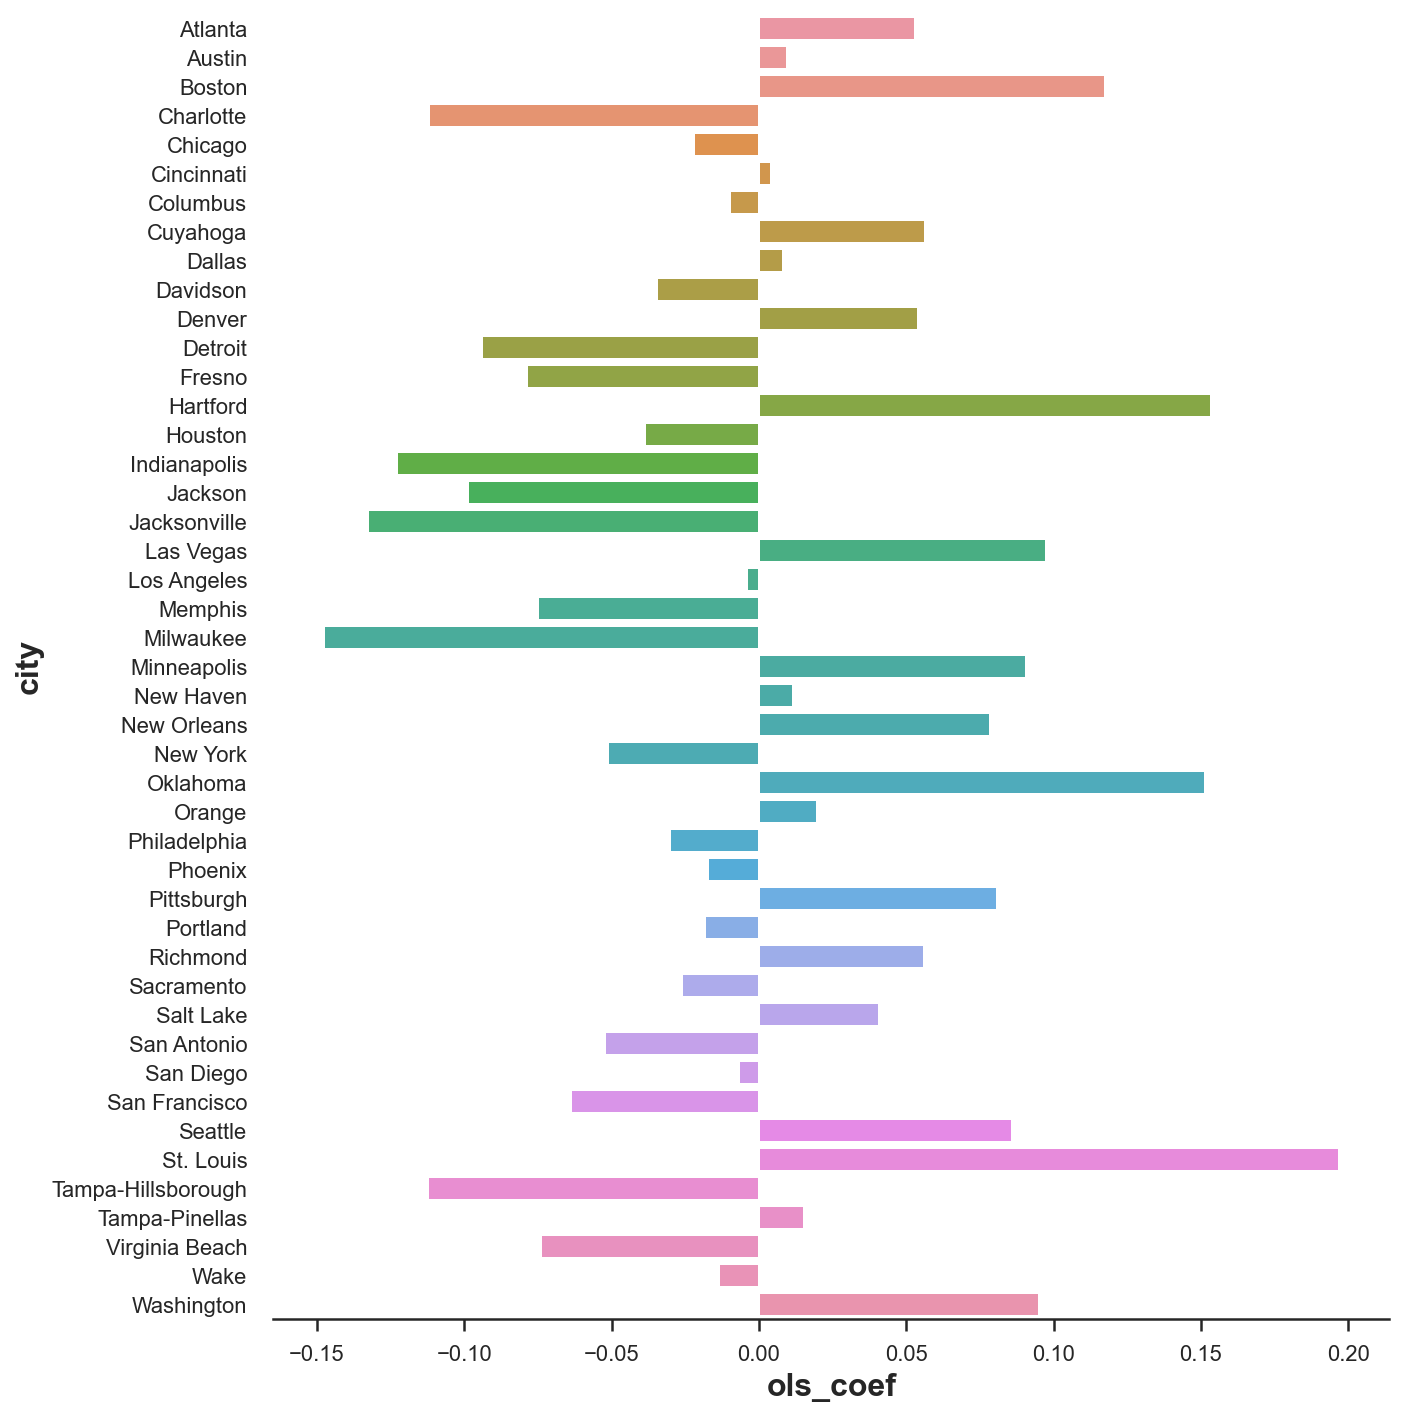

In [15]:
df_states = pd.DataFrame({'city': [c for c in cities if c!=treated_city], 'ols_coef': coef})
plt.figure(figsize=(10, 12))
sns.barplot(data=df_states, x='ols_coef', y='city');

We have many **negative weights**, which do not make much sense from a causal inference perspective. I can understand that Miami can be expressed as a combination of 0.2 St. Louis, 0.15 Oklahoma and 0.15 Hartford. But what does it mean that Miami is -0.15 Milwaukee?

Since we would like to interpret our synthetic control as a **weighted average** of untreated states, all weights should be positive  and they should sum to one.  

To address both concerns (weighting and overfitting), we need to impose some **restrictions on the weights**.

## Extensions

### Weights

To solve the problems of overweighting and negative weights, [Abadie, Diamond and Hainmueller (2010)](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) propose the following weights:

$$
\hat \beta = \arg \min_{\beta} || \boldsymbol X_t - \boldsymbol \beta \boldsymbol X_c || = \sqrt{ \sum_{p} \left( X_{t, p}  - \sum_{i \in c} \beta_{p} X_{c, p} \right)^2 }
\quad \text{s.t.} \quad \sum_{p} \beta_p = 1 \quad \text{and} \quad \beta_p \geq 0 \quad \forall p
$$

Which means, a set of weights $\beta$ such that 

- weighted observable characteristics of the control group $X_c$, match the observable characteristics of the treatment group $X_t$, before the treatment

- they sum to 1 

- and are not negative.

With this approach we get an **interpretable counterfactual** as a weighted avarage of untreated units.

Let's write now our own objective function. I create a new class `SyntheticControl()` which has both a `loss` function, as described above, a method to `fit` it and `predict` the values for the treated unit.

In [16]:
from toolz import partial
from scipy.optimize import fmin_slsqp

class SyntheticControl():
    
    # Loss function
    def loss(self, W, X, y) -> float:
        return np.sqrt(np.mean((y - X.dot(W))**2))

    # Fit model
    def fit(self, X, y):
        w_start = [1/X.shape[1]]*X.shape[1]
        self.coef_ = fmin_slsqp(partial(self.loss, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
        self.mse = self.loss(W=self.coef_, X=X, y=y)
        return self
    
    # Predict 
    def predict(self, X):
        return X.dot(self.coef_)

We can now repeat the same procedure as before, but using the `SyntheticControl` method instead of the simple, unconstrained `LinearRegression`.

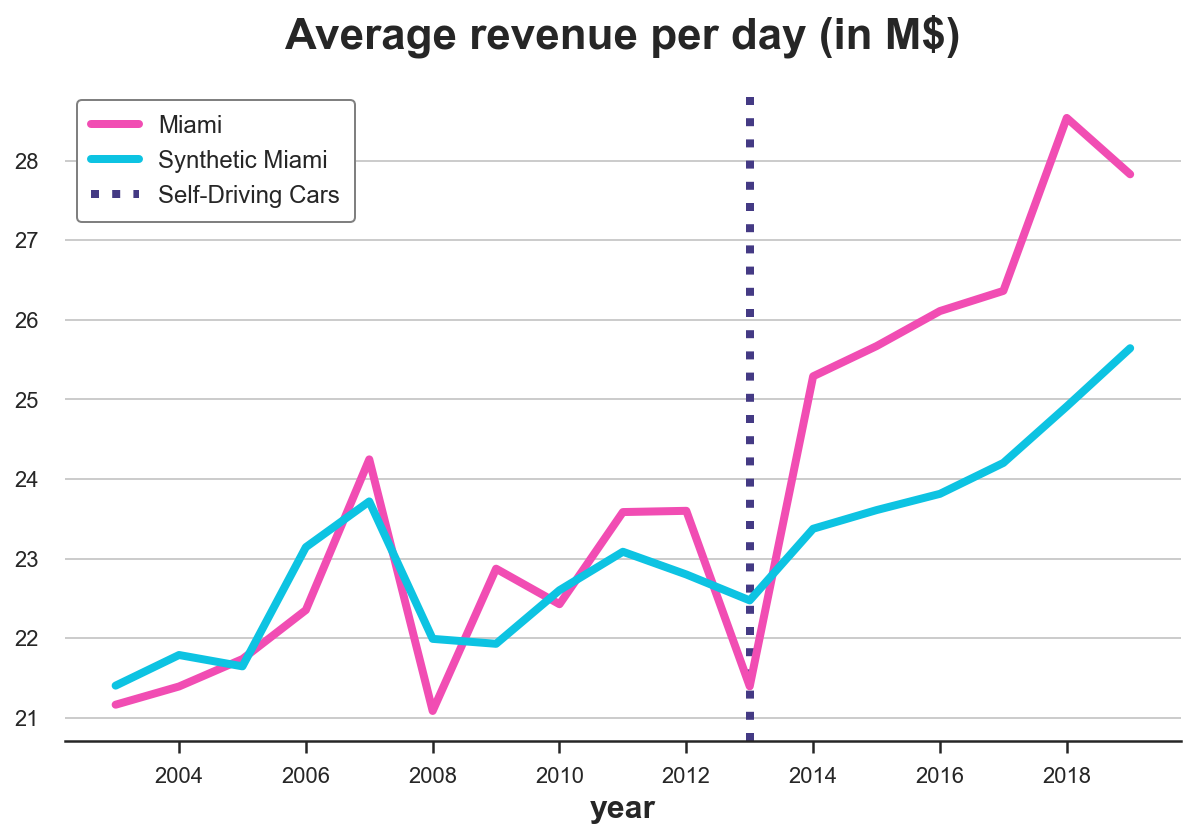

In [17]:
df_states['coef_synth'] = synth_predict(df, SyntheticControl(), treated_city, treatment_year).coef_
plot_lines(df, treated_city, f'Synthetic {treated_city}', treatment_year)

As we can see, now we are **not overfitting** anymore. The actual and predicted `revenue` pre-treatment are close but not identical. The reason is that the non-negativity constraint is constraining most coefficients to be zero (as [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) does).

It looks like the effect is again negative. However, let's plot the **difference** between the two lines to better visualize the magnitude.

In [18]:
def plot_difference(df, city, year, vline=True, hline=True, **kwargs):
    sns.lineplot(x=df['year'], y=df[city] - df[f'Synthetic {city}'], **kwargs)
    if vline: 
        plt.axvline(x=year, ls=":", color='C2', lw=3, label='Self-driving Cars', zorder=100)
        plt.legend()
    if hline: sns.lineplot(x=df['year'], y=0, lw=3, color='k', zorder=1)
    plt.title("Estimated effect of self-driving cars");

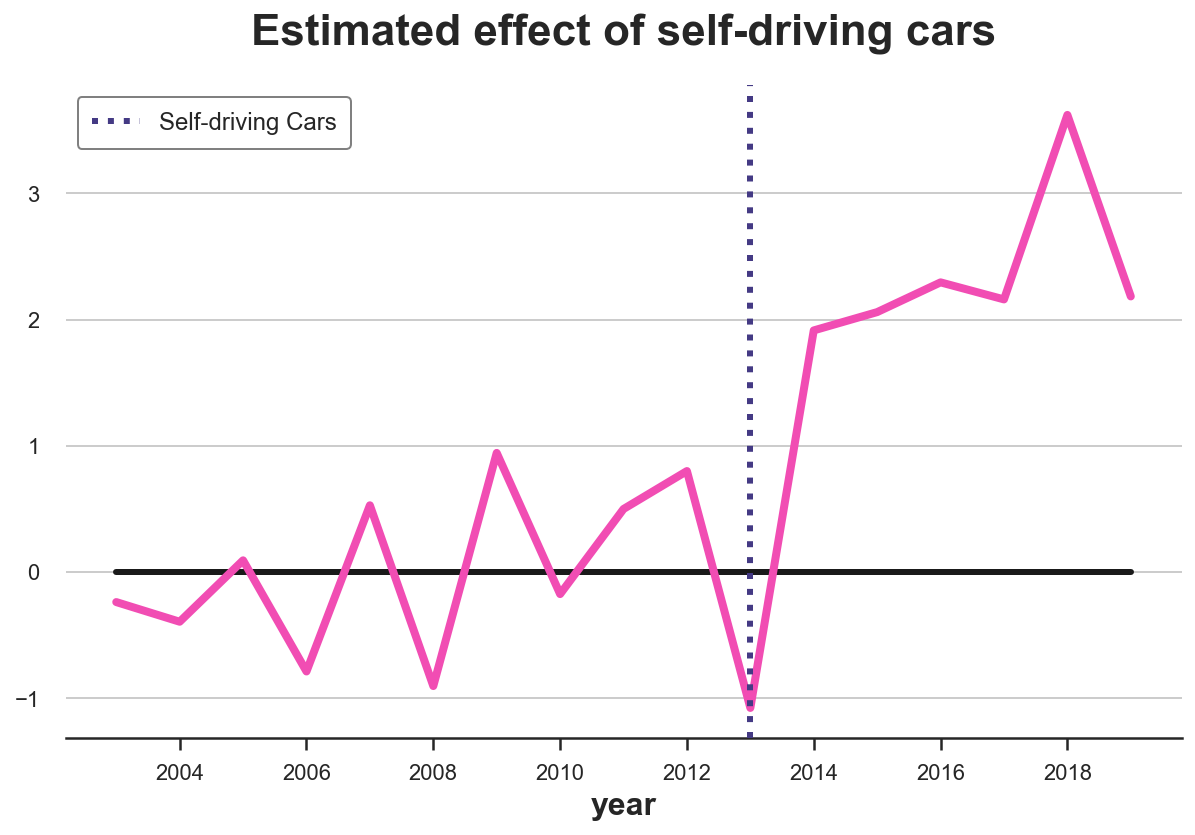

In [19]:
plot_difference(df, treated_city, treatment_year)

The difference is clearly positive and slightly increasing over time.

We can also visualize the **weights** to interpret the estimated counterfactual (what would have happened in Miami, without self-driving cars).

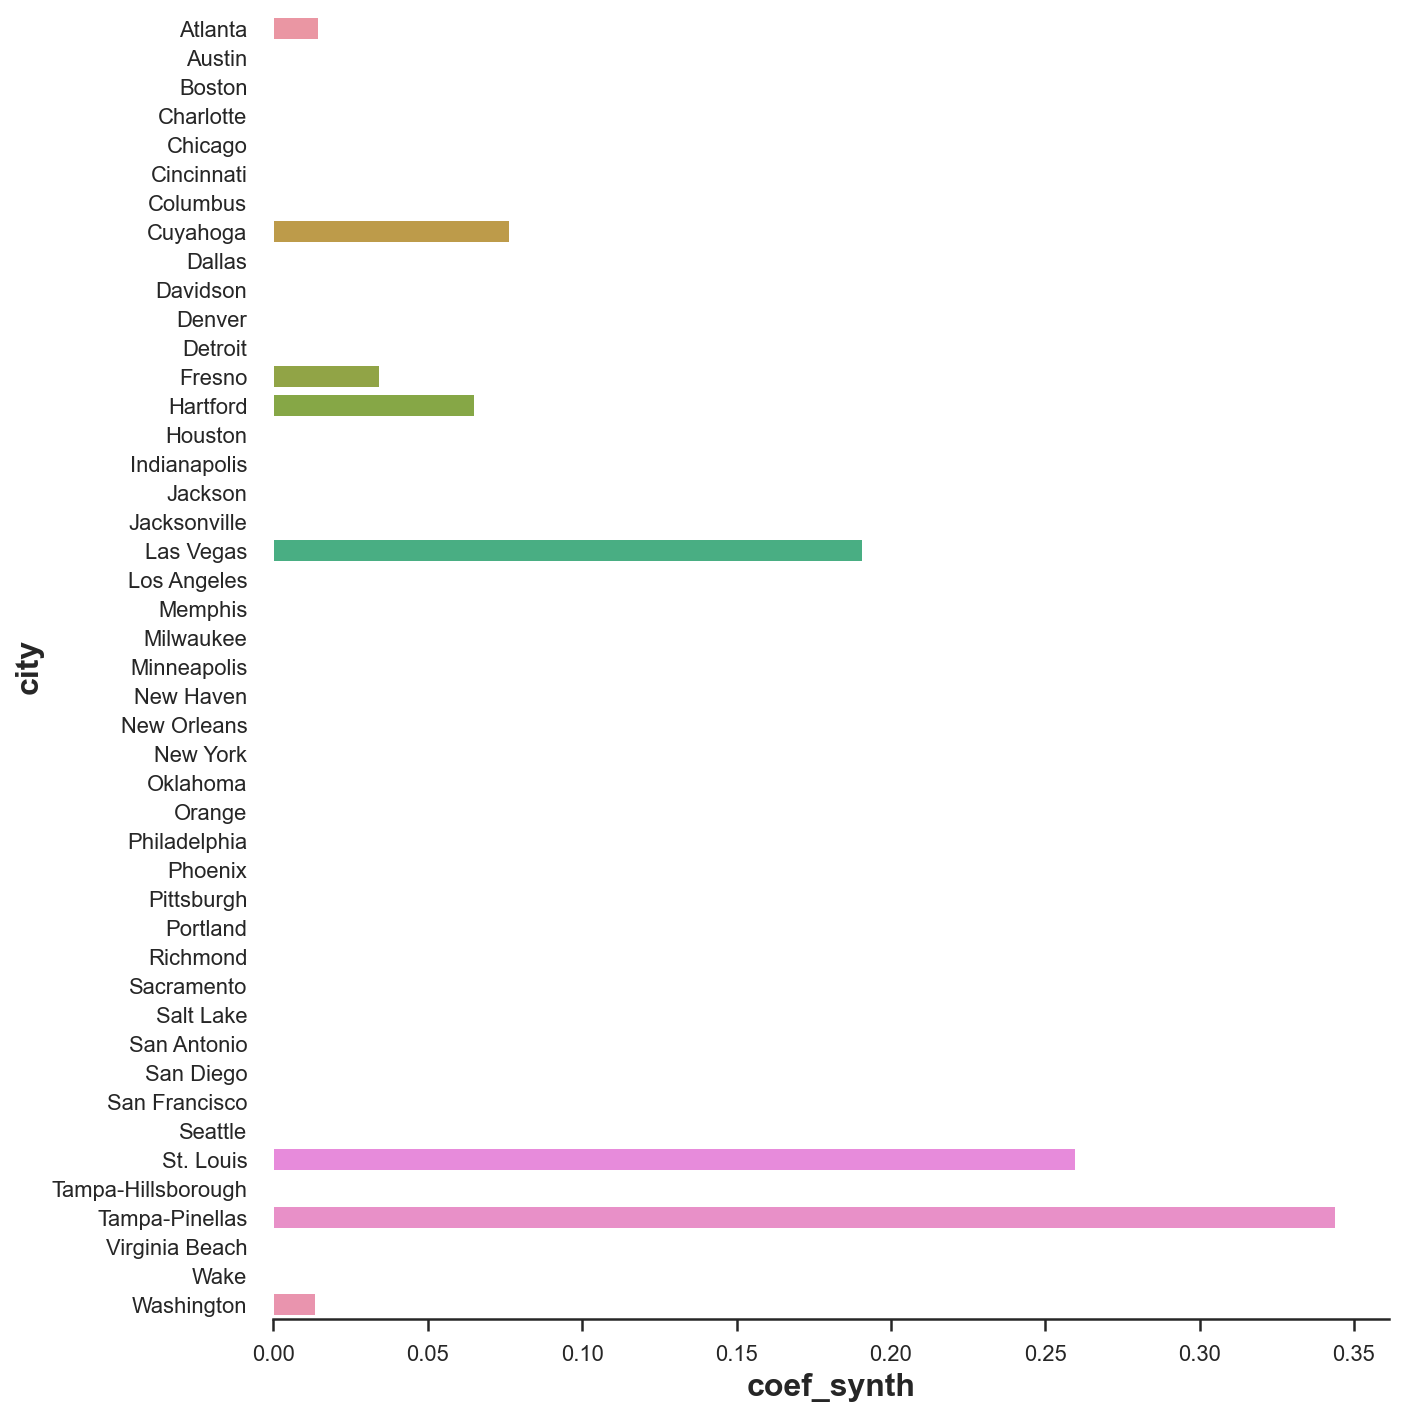

In [20]:
plt.figure(figsize=(10, 12))
sns.barplot(data=df_states, x='coef_synth', y='city');

As we can see, now we are expressing `revenue` in Miami as a linear combination of just a couple of cities: Tampa, St. Louis and, to a lower extent, Las Vegas. This makes the whole procedure very **transparent**.

### Inference

What about **inference**? Is the estimate significantly different from zero? Or, more practically, "*how unusual is this estimate under the null hypothesis of no policy effect*?". 

We are going to perform a [**randomization/permutation test**](https://en.wikipedia.org/wiki/Permutation_test) in order to answer this question. The **idea** is that if the policy has no effect, the effect we observe for Miami should not be significantly different from the effect we observe for any other city.

Therefore, we are going to replicate the procedure above, but for all other cities and compare them with the estimate for Miami.

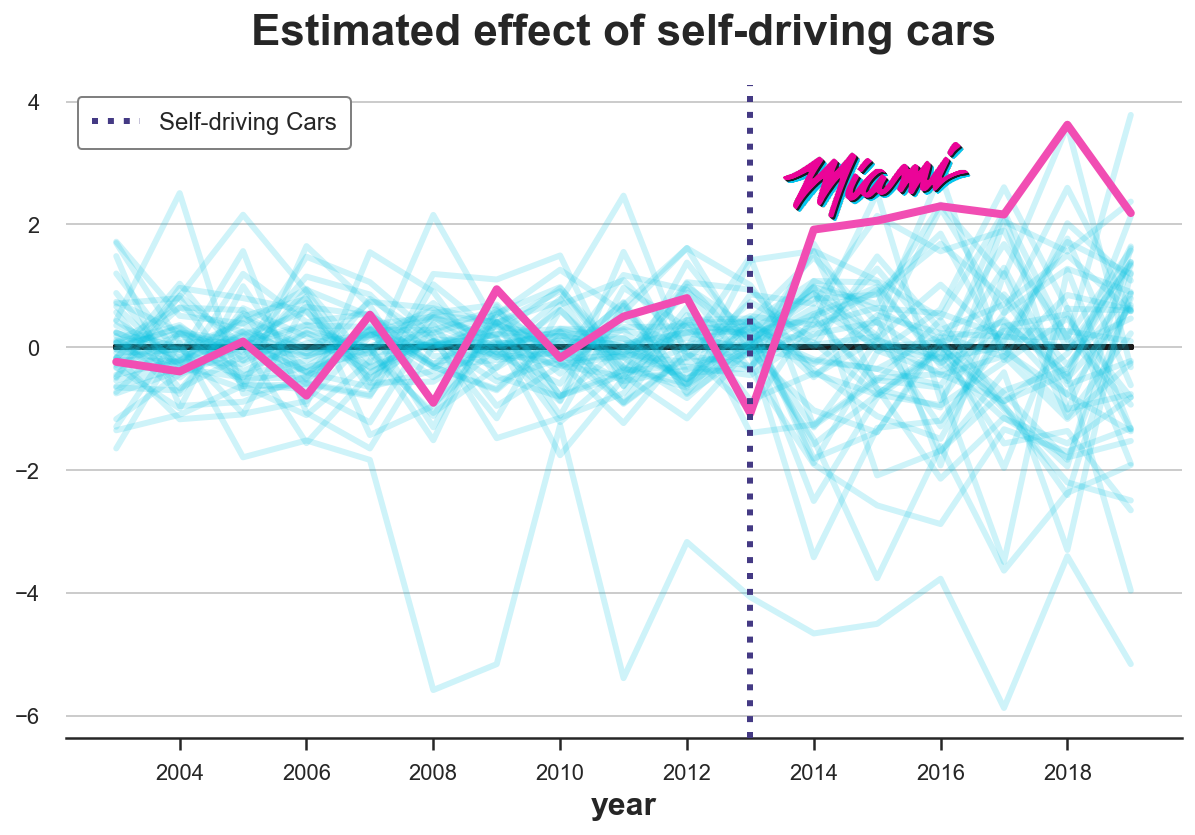

In [21]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots()
for city in cities:
    synth_predict(df, SyntheticControl(), city, treatment_year)
    plot_difference(df, city, treatment_year, vline=False, alpha=0.2, color='C1', lw=3)
plot_difference(df, treated_city, treatment_year)
ax.add_artist(AnnotationBbox(OffsetImage(plt.imread('fig/miami.png'), zoom=0.25), (2015, 2.7), frameon=False));

From the graph we notice two things. First, the effect for Miami is quite **extreme** and therefore likely not to be driven by random noise. 

Second, we also notice that there are a couple of cities for which we cannot fit the pre-trend very well. In particular, there is a line that is sensibly lower than all others. This is expected since, for each city, we are building the counterfactual trend as a **convex combination** of all other cities. Cities that are quite extreme in terms of `revenue` are very useful to build the counterfactuals of other cities, but it's **hard to build a counterfactual for them**.

Not to bias the analysis, let's exclude states for which we cannot build a "good enough" counterfectual, in terms of pre-treatment MSE. 

$$
MSE_{pre} = \frac{1}{n} \sum_{t \in \text{pre}} \left( Y_t - \hat Y_t \right)^2 
$$

As a rule of thumb, [Abadie, Diamond and Hainmueller (2010)](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) suggest to exclude units for which the prediction MSE is larger than twice the MSE of the treated unit.

In [ ]:
# Reference mse
mse_treated = synth_predict(df, SyntheticControl(), treated_city, treatment_year).mse

# Other mse
fig, ax = plt.subplots()
for city in cities:
    mse = synth_predict(df, SyntheticControl(), city, treatment_year).mse
    if mse < 2 * mse_treated:
        plot_difference(df, city, treatment_year, vline=False, alpha=0.2, color='C1', lw=3)
plot_difference(df, treated_city, treatment_year)
ax.add_artist(AnnotationBbox(OffsetImage(plt.imread('fig/miami.png'), zoom=0.25), (2015, 2.7), frameon=False));

After exluding extreme observations, it looks like the effect for Miami is very unusual. 

One **statistic** that [Abadie, Diamond and Hainmueller (2010)](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) suggest to perform a randomization test is the ratio between pre-treatment MSE and post-treatment MSE.

$$
\lambda = \frac{MSE_{post}}{MSE_{pre}} = \frac{\frac{1}{n} \sum_{t \in \text{post}} \left( Y_t - \hat Y_t \right)^2 }{\frac{1}{n} \sum_{t \in \text{pre}} \left( Y_t - \hat Y_t \right)^2 }
$$

We can compute a p-value as the number of observations with higher ratio.

In [ ]:
lambdas = {}
for city in cities:
    mse_pre = synth_predict(df, SyntheticControl(), city, treatment_year).mse
    mse_tot = np.mean((df[f'Synthetic {city}'] - df[city])**2)
    lambdas[city] = (mse_tot - mse_pre) / mse_pre
    
print(f"p-value: {np.mean(np.fromiter(lambdas.values(), dtype='float') > lambdas[treated_city]):.4}")

It seems that only $4.3\%$ of the cities had a larger MSE ratio than Miami, implying a p-value of 0.043. We can visualize the distribution of the statistic under permutation with a histogram.

In [ ]:
fig, ax = plt.subplots()
_, bins, _ = plt.hist(lambdas.values(), bins=20, color="C1");
plt.hist([lambdas[treated_city]], bins=bins)
plt.title('Ratio of $MSE_{post}$ and $MSE_{pre}$ across cities');
ax.add_artist(AnnotationBbox(OffsetImage(plt.imread('fig/miami.png'), zoom=0.25), (2.7, 1.6), frameon=False));

Indeed, the statistic for Miami is quite extreme.

### Synthetic Control vs Other Methods

What are the advantages and disadvantages of synthetic control methods with respect to other methods?

1. As long as we use positive weights that are constrained to sum to one, the method **avoids extrapolation**: we will never go out of the support of the data
    
2. It can be **"pre-registered"** in the sense that you don't need post-treatment observations to build the method: could avoid p-hacking and cherry picking
    
3. Weights make the counterfactual analysis **explicit**: one can look at the weights and understand which comparison we are making
    
4. It's a **bridge** between quantitative and qualitative research: can be used to inspect single-treated unit cases

## Conclusion

TBD

### References

[1] A. Abadie, A. Diamond and J. Hainmueller, [Synthetic Control Methods for Comparative Case Studies: Estimating the Effect of California’s Tobacco Control Program](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) (2010), *Journal of the American Statistical Association*.

[2] A. Abadie, J. L'Hour, [A Penalized Synthetic Control Estimator for Disaggregated Data](https://www.tandfonline.com/doi/full/10.1080/01621459.2021.1971535) (2020), *Journal of the American Statistical Association*.

[3] N. Doudchenko, G. Imbens, [Balancing, Regression, Difference-In-Differences and Synthetic Control Methods: A Synthesis](https://arxiv.org/pdf/1610.07748.pdf) (2017), *working paper*.

[] Matrix completion methods for causal panel data models

[] Using Synthetic Controls: Feasibility, Data Requirements, and Methodological Aspects

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/synth.ipynb